In [7]:
from models import create_mlp
from process_data import load_house_attributes, process_house_attributes
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import numpy as np
import argparse
import locale
import os

In [8]:
DATASET_PATH = "keras-regression/Houses-dataset/Houses Dataset/HousesInfo.txt"

In [9]:
df = load_house_attributes(DATASET_PATH)

In [10]:
(train, test) = train_test_split(df, test_size=0.25, random_state=42)

In [11]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (this will lead to
# better training and convergence)
maxPrice = train["price"].max()
trainY = train["price"] / maxPrice
testY = test["price"] / maxPrice

In [12]:
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
print("[INFO] processing data...")
(trainX, testX) = process_house_attributes(train, test, "price")

[INFO] processing data...


/Users/anhoang/anaconda3/envs/cv-hw/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/anhoang/anaconda3/envs/cv-hw/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/anhoang/Documents/personal-learning/Real_Estate/py_img_search/part1/process_data.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [13]:
trainX

,bedrooms,bathrooms,area,zipcode_91901,zipcode_92276,zipcode_92677,zipcode_92880,zipcode_93446,zipcode_93510,zipcode_94501
148,0.444444,0.454545,0.562629,0,0,1,0,0,0,0
337,0.111111,0.181818,0.075409,0,1,0,0,0,0,0
444,0.222222,0.363636,0.333227,0,0,0,0,0,1,0
269,0.333333,0.363636,0.344340,0,0,0,1,0,0,0
362,0.111111,0.181818,0.117320,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
181,0.222222,0.272727,0.235593,0,0,0,0,0,0,1
228,0.444444,0.727273,0.476266,0,0,0,1,0,0,0
412,0.111111,0.181818,0.102080,0,1,0,0,0,0,0
490,0.222222,0.181818,0.223369,0,0,0,0,1,0,0


In [21]:
# create our MLP and then compile the model using mean absolute
# percentage error as our loss, implying that we seek to minimize
# the absolute percentage difference between our price *predictions*
# and the *actual prices*
model = create_mlp(trainX.shape[1], regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics = ["accuracy"])
 
# train the model
print("[INFO] training model...")
history = model.fit(trainX, trainY, validation_data=(testX, testY),
	epochs=200, batch_size=8)

[INFO] training model...
Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 1s 3ms/step - loss: 172.8514 - acc: 0.0000e+00 - val_loss: 150.7431 - val_acc: 0.0000e+00
Epoch 2/200
271/271 [==============================] - 0s 431us/step - loss: 100.7064 - acc: 0.0000e+00 - val_loss: 103.1149 - val_acc: 0.0000e+00
Epoch 3/200
271/271 [==============================] - 0s 425us/step - loss: 79.6213 - acc: 0.0000e+00 - val_loss: 87.6870 - val_acc: 0.0000e+00
Epoch 4/200
271/271 [==============================] - 0s 527us/step - loss: 73.0200 - acc: 0.0000e+00 - val_loss: 83.7858 - val_acc: 0.0000e+00
Epoch 5/200
271/271 [==============================] - 0s 505us/step - loss: 69.8390 - acc: 0.0000e+00 - val_loss: 78.9139 - val_acc: 0.0000e+00
Epoch 6/200
271/271 [==============================] - 0s 518us/step - loss: 66.8744 - acc: 0.0000e+00 - val_loss: 76.0543 - val_acc: 0.0000e+00
Epoch 7/200
271/271 [==============================] - 0s 

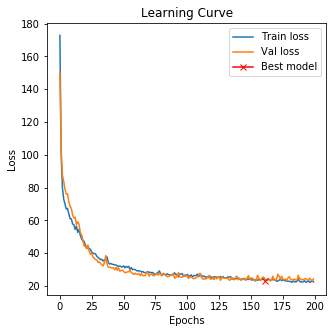

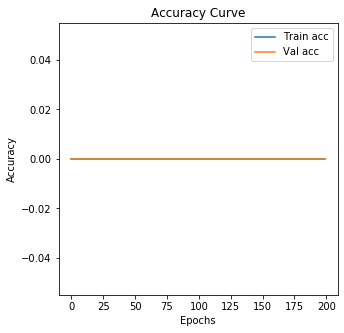

In [22]:
import matplotlib.pyplot as plt
results = history
plt.figure(figsize=(5,5))
plt.plot(results.history["loss"], label='Train loss')
plt.plot(results.history["val_loss"], label='Val loss')
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker='x', color='r', label='Best model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

# plot accuracy
plt.figure(figsize=(5,5))
plt.plot(results.history["acc"], label='Train acc')
plt.plot(results.history["val_acc"], label='Val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [23]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(testX)
 
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
 
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] predicting house prices...
[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 24.28%, std: 22.44%
